In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries imported successfully!
Dataset '/content/drive/MyDrive/MELBOURNE_HOUSE_PRICES_LESS.csv' loaded successfully.
Original shape: (63023, 13)

--- Starting Data Cleaning ---

Dropped columns with high missing values: []
Shape after dropping rows with missing Price: (48433, 13)

Missing values have been imputed.


/tmp/ipython-input-1977346886.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(mode_val, inplace=True)


Remaining missing values per column:
 Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Postcode         0
Regionname       0
Propertycount    0
Distance         0
CouncilArea      0
dtype: int64

--- Correcting Data Types ---
Data types corrected. New info:
<class 'pandas.core.frame.DataFrame'>
Index: 48433 entries, 0 to 63020
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         48433 non-null  object        
 1   Address        48433 non-null  object        
 2   Rooms          48433 non-null  int64         
 3   Type           48433 non-null  object        
 4   Price          48433 non-null  float64       
 5   Method         48433 non-null  object        
 6   SellerG        48433 non-null  object        
 7   Date           48433 non-null  datetime64[ns]
 8   Postcode       48433

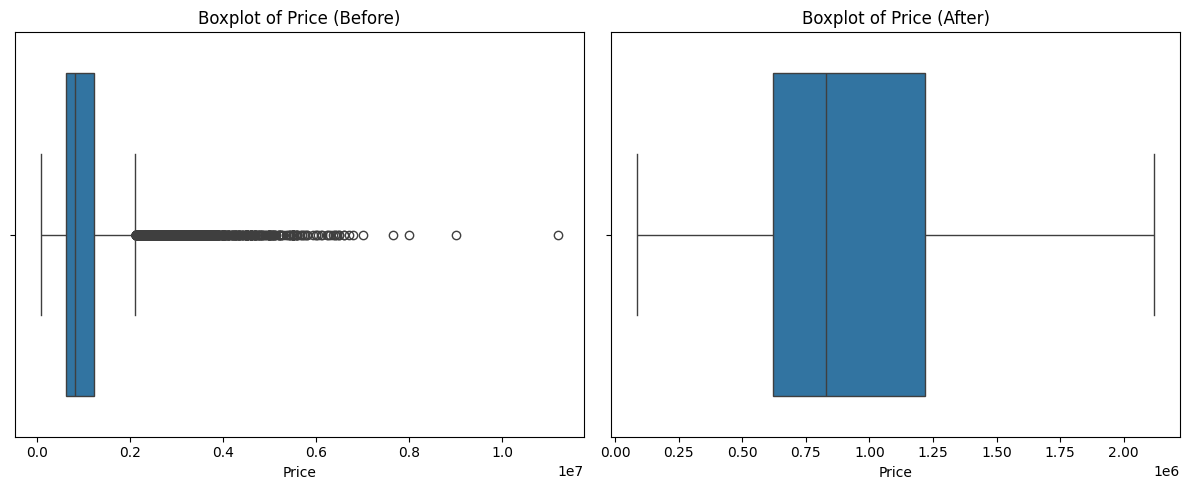


--- Preprocessing Complete! ✨ ---

Final shape of the cleaned dataset: (48433, 14)

First 5 rows of the final, clean dataset:
         Suburb           Address  Rooms Type      Price Method   SellerG  \
0    Abbotsford     49 Lithgow St      3    h  1490000.0      S    Jellis   
1    Abbotsford     59A Turner St      3    h  1220000.0      S  Marshall   
2    Abbotsford     119B Yarra St      3    h  1420000.0      S    Nelson   
3    Aberfeldie        68 Vida St      3    h  1515000.0      S     Barry   
4  Airport West  92 Clydesdale Rd      2    h   670000.0      S    Nelson   

        Date  Postcode             Regionname  Propertycount  Distance  \
0 2017-04-01      3067  Northern Metropolitan           4019       3.0   
1 2017-04-01      3067  Northern Metropolitan           4019       3.0   
2 2017-04-01      3067  Northern Metropolitan           4019       3.0   
3 2017-04-01      3040   Western Metropolitan           1543       7.5   
4 2017-04-01      3042   Western Metropo

In [3]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

# 2. LOAD THE DATA
# This 'try-except' block will prevent the 'NameError' by checking if the file exists.
file_path = '/content/drive/MyDrive/MELBOURNE_HOUSE_PRICES_LESS.csv'
df = None
try:
    df = pd.read_csv(file_path)
    print(f"Dataset '{file_path}' loaded successfully.")
    print(f"Original shape: {df.shape}")
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"The file '{file_path}' was not found. Please upload it to your Colab session.")
    print("The rest of the script will not run until the file is available.")

# 3. RUN CLEANING ONLY IF THE DATAFRAME WAS LOADED SUCCESSFULLY
if df is not None:
    # --- DATA CLEANING AND PREPROCESSING ---
    print("\n--- Starting Data Cleaning ---")

    # Strategy 1: Drop columns with more than 40% missing values
    missing_percentage = df.isnull().sum() / len(df) * 100
    cols_to_drop = missing_percentage[missing_percentage > 40].keys()
    df_cleaned = df.drop(columns=cols_to_drop)
    print(f"\nDropped columns with high missing values: {list(cols_to_drop)}")

    # Strategy 2: Drop rows where the target 'Price' is missing
    df_cleaned.dropna(subset=['Price'], inplace=True)
    print(f"Shape after dropping rows with missing Price: {df_cleaned.shape}")

    # Strategy 3: Impute remaining missing values
    # Numerical columns get the median
    for col in ['Bathroom', 'Car', 'Lattitude', 'Longtitude']:
        if col in df_cleaned.columns:
            median_val = df_cleaned[col].median()
            df_cleaned[col].fillna(median_val, inplace=True)

    # Categorical columns get the mode
    for col in ['CouncilArea', 'Regionname']:
        if col in df_cleaned.columns:
            mode_val = df_cleaned[col].mode()[0]
            df_cleaned[col].fillna(mode_val, inplace=True)

    print("\nMissing values have been imputed.")
    # Verify no missing values are left
    print("Remaining missing values per column:\n", df_cleaned.isnull().sum())

    # --- CORRECTING DATA TYPES ---
    print("\n--- Correcting Data Types ---")
    df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%d/%m/%Y')

    for col in ['Bathroom', 'Car', 'Postcode', 'Propertycount']:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].astype(int)

    print("Data types corrected. New info:")
    df_cleaned.info()

    # --- FEATURE ENGINEERING ---
    print("\n--- Starting Feature Engineering ---")
    # Let's create a new feature: Age of the house
    # We will use a reference date of 2018-01-01, as our data is from before then
    current_date = pd.to_datetime('2018-01-01')
    df_cleaned['Age_of_House'] = (current_date - df_cleaned['Date']).dt.days / 365.25
    print("New feature 'Age_of_House' created.")
    print(df_cleaned[['Date', 'Age_of_House']].head())

    # --- HANDLING OUTLIERS ---
    print("\n--- Handling Outliers ---")

    # Visualize 'Price' before capping
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
    sns.boxplot(x=df_cleaned['Price'])
    plt.title('Boxplot of Price (Before)')
    print("Displaying boxplot for 'Price' before outlier capping...")

    # Capping logic using IQR
    for col in ['Price']:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound,
                                   np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col]))

    print("Outliers have been capped for 'Price' using the IQR method.")

    # Visualize 'Price' after capping
    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
    sns.boxplot(x=df_cleaned['Price'])
    plt.title('Boxplot of Price (After)')
    plt.tight_layout()
    plt.show()

    # --- FINAL RESULT ---
    print("\n--- Preprocessing Complete! ✨ ---")
    print("\nFinal shape of the cleaned dataset:", df_cleaned.shape)
    print("\nFirst 5 rows of the final, clean dataset:")
    print(df_cleaned.head())